<h4>Lily Grumbach
    <br>M1 Humanités numériques - Université PSL</h4>
<h1><center>Rendu TAIS-TAL </center></h1>
<h2><center>Partie TAIS</center></h2>
<h3><center>3/3 : Géoréférencer les entités nommées de mes revues</center></h3>

<b><u>PLAN:</u></b>
1) Harmonisation des données Géopolitiques pour le fond de carte de 1914
<br>
    
2) Explorer les bases de données à ma disposition (IREL et GPH) et les préparer pour l'extraction des coordonnées géographiques
<br/>
    
<h4>3) Géoréférencer les entités nommées de mes revues</h4>

<b>Stratégie en place :  </b>

Nous avons 3 sources possibles de désambiguisation : 
* **Wikidata** indiqués par le medialab 
* l'**IREL**, la base de données géographique de l'inventaire en ligne des Archives nationales d'Outre Mer
* **Geonames**, pour le meilleur et pour le pire.

<h3>Objectifs de la partie : </h3>

Mettre en place une base de données destinée à être exploitée sur QGIS

In [75]:
#Généraux
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [76]:
#Coordonnées par lieu
df_coord=pd.read_csv("./output_finaux/TERMINE_MANUELLEMENT_COORD_GPH_IREL_GPELOC.tsv",sep="\t")
df_coord=df_coord.set_index("NAME")

#Revues
df_AHMC=pd.read_csv("./df_annotes/dfAHMCannotations.csv")
df_AMN=pd.read_csv("./df_annotes/dfAMNannotations.csv")

#Données IREL
df_IREL_url = pd.read_csv("./desambiguisation/IREL_ens_url.csv")
df_IREL=df_IREL_url[["Administration","NAME","titre"]]

# 1. Création d'un dictionnaire pour pouvoir attribuer à chaque "clé" le lieu attribué. 

In [77]:
dico_lat = df_coord["latitude"].to_dict()
dico_long = df_coord["longitude"].to_dict()

dico_coord={}
for key in dico_lat.keys():
    dico_coord[key]=[dico_lat[key],dico_long[key]]
# dico_coord

#### On a remarqué la présence de plusieurs faux positifs dans notre liste :
"Annamite","Annamites","île","Japonais","Nord","Phlégéton","Bambaras","Croyances","Malgaches","Surra","Caldwelle-Luc","Danaïde","Gaulois"

Nous ne les avons pas mis dans les dictionnaireslong/lat mais en réalité, on peut associer certains de ces faux positifs à une coordonnée.

Par exemple : "Malgaches"=>Madagascar

In [78]:
dico_coord["Annamite"]=dico_coord["Annam"]
dico_coord["Annamites"]=dico_coord["Annam"]
dico_coord["Japonais"]=dico_coord["Japon"]
dico_coord["Bambaras"]=dico_coord["Haut-Sénégal"] #On a préféré Haut-Sénégal à "Sénégal" car ce dernier est trop restreint géographiquement
dico_coord["Malgaches"]=dico_coord["Madagascar"]

ListeFP=["île","Nord","Phlégéton","Croyances","Surra","Caldwelle-Luc","Danaïde","Gaulois"] #"Gaulois" fait référence au nom d'un bateau

In [79]:
#Extraction des entités GPE/LOC
df_AMN_GPELOC=df_AMN.loc[:,"article_titre":"LOC_ents"]
df_AHMC_GPELOC = df_AHMC.loc[:,"article_titre":"LOC_ents"]

# Création d'une Serie "revue" pour "keep track"
df_AMN_GPELOC.insert(0, 'revue', 'AMN')
df_AHMC_GPELOC.insert(0, 'revue', 'AHMC')

#concaténation AHMC et AMN: 
df_AMN_AHMC_GPELOC=pd.concat([df_AHMC_GPELOC,df_AMN_GPELOC],ignore_index=True)

In [80]:
df_AMN_AHMC_GPELOC

,revue,article_titre,revue_annee,GPE_ents,LOC_ents
0,AHMC,Contribution à la géographie médicale. Notes s...,1898,"Dakar,Sénégal",NaN
1,AHMC,Notes sur la mortalité des troupes d'infanteri...,1898,Cochinchine,NaN
2,AHMC,Sur le mécanisme de l'immunisation contre les ...,1898,NaN,NaN
3,AHMC,Note succinte sur l’état sanitaire de nos colo...,1898,NaN,NaN
4,AHMC,Clinique d'Outre-Mer. Contribution à l'étude d...,1898,"My-Tho,Cochinchine",NaN
...,...,...,...,...,...
1192,AMN,"Une page d'hygiène professionnelle, par le doc...",1908,NaN,NaN
1193,AMN,"Le rein polykystique de l'adulte, par le Dr Da...",1908,NaN,NaN
1194,AMN,Explosion d'un collecteur de vapeur à bord du ...,1908,NaN,NaN
1195,AMN,"Trois abcès du foie ouverts dans le péricarde,...",1908,NaN,NaN


## Exploration

## Séparation des différentes entités nommées trouvées pour un même article 
Seulement le cas pour `GPE` car dans notre cas il n'y a qu'une seule entité `LOC`  par article

In [81]:
df_AMN_AHMC_LOC=df_AMN_AHMC_GPELOC["LOC_ents"].str.split(r"\,",expand=True)
df_AMN_AHMC_GPE=df_AMN_AHMC_GPELOC["GPE_ents"].str.split(r"\,",expand=True)

### `LOC` : 

Concernant les EN `LOC`, on remarque quelques Faux Positifs qui auraient dû être associés à GPE : Nouméa,Yen-Thé,Binh-Thuan, cercle de Thiès, casamance.

Le reste des `LOC` sont bien référencées. On notera tout de même que dans notre démarche atuomatique/manuelle de géolocalisation des entités nommées,nous avons eu recours, pour les balises `LOC`, généralement assez vaguesque nous avonseu recours au service en ligne de <a href='http://www.geonames.org/'>geonames</a>

In [82]:
print("Liste des entités `LOC trouvées:") 
# df_AMN_AHMC_LOC.loc[df_AMN_AHMC_LOC[0].notnull()].groupby(by=0).count()

df_AMN_AHMC_GPELOC.loc[df_AMN_AHMC_GPELOC["LOC_ents"].notnull()] 
#En général, les LOC sont les seuls références de l'article

Liste des entités `LOC trouvées:


,revue,article_titre,revue_annee,GPE_ents,LOC_ents
29,AHMC,Rapport sur les opérations de vaccination prat...,1899,NaN,Ogooué
261,AHMC,Fonctionnement du laboratoire de bactériologie...,1903,Calédonie,Nouméa
317,AHMC,Fonctionnement du service vaccinogène de Noumé...,1904,Calédonie,Nouméa
469,AHMC,Analyse de l'eau du Yang-Tsé et du fleuve jaune.,1907,NaN,Yang-Tsé
503,AHMC,Géographie médicale. Notes sur le Binh-Thuan (...,1907,Annam,Binh-Thuan
559,AMN,Rapport médical d'ensemble sur les colonnes du...,1898,NaN,Yen-Thé
668,AMN,"La lèpre dans le cercle de Thiès (Sénégal), pa...",1900,Sénégal,cercle de Thiès
669,AMN,Notes d'hygiène navale recueillies pendant une...,1900,NaN,océan Atlantique
709,AMN,Notes médicales recueillies pendant une campag...,1901,NaN,Océan Pacifique
742,AMN,"Une colonne en casamance (Mars-Mai 1901), par ...",1901,NaN,casamance


### `GPE` : 



In [83]:
df_AMN_AHMC_GPE.loc[df_AMN_AHMC_GPE[0].notnull()].groupby(by=0).sum()

,1,2,3,4
0,,,,
Abyssinie,0,0,0.0,0.0
Acores,0,0,0.0,0.0
Afrique,0,0,0.0,0.0
Afrique occidentale française,0,0,0.0,0.0
Algérie,NaN,NaN,NaN,NaN
...,...,...,...,...
île de Porquerolles,0,0,0.0,0.0
île de Saint-Barthélémy,0,0,0.0,0.0
île de Saint-Martin,0,0,0.0,0.0


#### Avoir une idée de la proportion de chaque `GPE` sur l'ensemble des deux revues
(on fait bien la différence avec les lieux car certaines EN sont assez vagues  ou sinon se recoupent.Ex:Saïgon,Tonkin )

<AxesSubplot:>

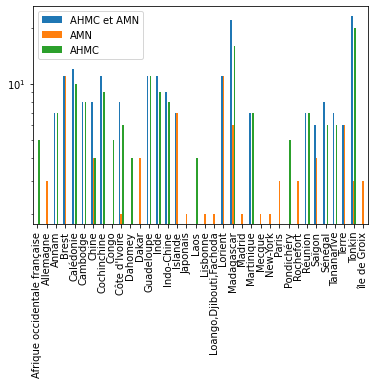

In [148]:
TopGPEAMN2plot=df_AMN_GPELOC.groupby(by="GPE_ents").count()["article_titre"].sort_values(ascending=False).head(20)
TopGPE_AMN_AHMC2plot = df_AMN_AHMC_GPELOC.groupby(by="GPE_ents").count()["article_titre"].sort_values(ascending=False).head(20)
TopGPE_AHMC2plot = df_AHMC_GPELOC.groupby(by="GPE_ents").count()["article_titre"].sort_values(ascending=False).head(20)

TOPmerged=pd.DataFrame({"AHMC et AMN":TopGPE_AMN_AHMC2plot,"AMN":TopGPEAMN2plot,"AHMC":TopGPE_AHMC2plot})
plot=TOPmerged.plot.bar(logy=True)
plot.get_figure().savefig("./output_finaux/images/Top20lieux.png")

plot

In [85]:
df_AMN_AHMC_GPE=df_AMN_AHMC_GPE.rename(columns={0:"GPE0",1:"GPE1",2:"GPE2",3:"GPE3",4:"GPE4"})
# df_AMN_AHMC_GPE

### Question : Quelles GPE conserver ?
Le problème principal lorsqu'il y a plus de 1 EN, est de savoir si elles concernent le même lieu.exemple :My-Tho et Cochinchine, auquel cas on ne conserveque My-Tho ou si ce sont des lieux très différents comme Madagascar et Tonkin.

On cherche donc : 

1) à estimer dans quelle mesure les EN correspondent au même lieu (avec certaines plus précises que d'autre). Le risque ici est de donner l'impression que les articles désignant "My-Tho" et "Cochinchine" soient deux articles différents alors qu'ils concernent le même lieu. 


2) Dans le cas où les GPE désignent le même lieu, ne retenir que le plus précis. Dans le cas mentionné, ce serait de faviriser "My-Tho" plutôt que "Cochinchine"

Je me rends compte que j'aurai dû ajouter à mon df de lieux, un indicateur sur le statut de l'EN.

In [86]:
# REtirer les "#" pour voir la liste des articles contenant plusieurs GPE 

# Liste des GPE ayant plus de 1 entité :
# for GPE in df_AMN_AHMC_GPELOC["GPE_ents"]:
#     if type(GPE)==str:
#         if re.search(",",GPE):
# #             print(GPE)

In [87]:
##Création d'un dictionnaire applicable uniquement à nos données. A l'avenir, il faudra avoir recours au df_IREL
##Ce dictionnaire répond au besoin de spécification PAR LIGNE.

dico_doubleGPE ={
    "Sénégal":["Dakar","Saint-Louis","Rufisque" ],
    "Madagascar":["Tamatave","Antsirane","Androy","Tananarive","Diégo-Suarez"],
    "Tonkin" : ["Laokay","Yen-Bay","Lao-Kay","Loncay"],
    "Japon" : ["Tokyo","Hiroshima"],
    "Annam": ["Vinh","Nhatrang"],
    "Fouta-Djallon" : ["Timbo"], #le Fouta-Djallon est le nom d'une région d'après le nomd'une montagne dans l'actuel Bénin
    "Liptako" : ["Dori"], #Dori est une ville de la région du Liptako
    "Cochinchine" : ["Saïgon","Cholon","My-Tho"],
    "Chine":["Pak-Hoï","Tchentou","Yunnan","Yun-Nan","Yunnam","Mongtzé","Ping-Shiang"],#Correspond aujourd'hui à la baie de Beihai
    "Yunnam":["Mongtzeu"],
    "Yunnan":["Mongtzeu"],
    "Setchouen":["Tchen-Tou"],
    "Malagches":["Tananarive"],#On est conscient du contresens mais c'est une nécessité en raison des faux positifs
    "Annamites":["Hué"],
    "Se-Tchouen":["Tchen-Tou"],
    "Indo-Chine":["Kampot"], # la mention conjointe de "Indo-Chine et "Yun-Nam" fait référence à deux lieux différents
    "Réunion":["Port","Saint-Philippe","Bras-de-Pontho"],
    "Guinée française":["Conakry","Ouossou"],
    "Tagant":["Tidjikdja"],
    "Mauritanie":["Tidjikdja"],
    "Barbade":["Bridgetown"],
    "Niger":["Kayes"],
    "Mexique":["Orizaba"],
    "Afrique":["Lagos"],
    "Rio":["Janeiro"],
    "Soudan":["Nioro"],
    "Tchad":["Bokoro"],
    "Algérie":["Constantine"]
}

#Pour remarque suivante : 
df_AMN_AHMC_GPELOC.loc[df_AMN_AHMC_GPELOC["GPE_ents"]=="Congo,Congo,Congo"]

,revue,article_titre,revue_annee,GPE_ents,LOC_ents
376,AHMC,Le ver blanc des cases indigènes au Congo (Lar...,1905,"Congo,Congo,Congo",NaN


On remarque aussi que quelques articles mentionnent plusieurs fois la mêmem EN. Par exemple, dans les AHMC en 1905, un titre d'article comprend 3 fois la même EN "Congo" :

 `"Le ver blanc des cases indigènes au `**Congo** `(Larve de diptère suceuse de sang observée dans l'`**état libre de Congo**`). Premier rapport (pendant l'intérim) de l'expédition de l'École de médecine tropicale de Liverpool au` **Congo**`, 1903, par E. J. Dutton, J. L. Todd et C. Christy, traduit de l'anglais.") "`
 => Cela nous indique d'ailleurs que le "Congo" auquel ils se réfèrent est "l'Etat libre de Congo" et non le Congo français.
 
 
Par contre, le cas de la double mention "Maroc" et "Maroc". Est en fait le résultat d'une erreur de séparation des articles. En effet, apparaît à la même ligne 2 articles différents,séparés par un "/" : 

`"Défense de la méditerranée contre le pèlerinage de la Mecque. Organisation sanitaire du Maroc, par le Dr Torel,  / État actuel du Maroc. Absence de toute notion d'hygiène"`

Voir ci-dessous : 

In [88]:
df_AMN_AHMC_GPELOC.loc[df_AMN_AHMC_GPELOC["GPE_ents"]=="Mecque,Maroc,Maroc"]

,revue,article_titre,revue_annee,GPE_ents,LOC_ents
792,AMN,Défense de la méditerranée contre le pèlerinag...,1902,"Mecque,Maroc,Maroc",NaN


### Pour une application générale de cette méthode : avoir recours à l'IREL
Pour cela,on pourrait avoir recours aux données de l'IREL qui contiennent déjà les relations d'appartenance mais cela n'étant pas suffisant à notre avis, nous allons le faire directement à la main pour cette fois ci. 


Ci-dessous nous avons créé un dictionnaire à améliorer encore mais qui permet de rattacher à chaque sous-entité du niveau "Administration" que nous avons définit dans la partie 2 l'ensemble des noms de lieux rattachés. Nous avons néanmoins pour l'instant omis le type de lieu pour gagner en lisibilité et pour pouvoir l'appliquer sans trop de problèmes à nos sources (qui ne font pas toujours mention du type de lieu). Autre problème : les etités séparées par des "/" et les " ' " qui ne sont pas passés et ont été remplacés par "\'"

**Pour amélioration :** Faire au préalable un df avec 2 indexs car on trouve beaucoup de répétititon dans notre dictionnaire.

In [89]:
df_IREL.groupby(by="Administration").sum()

#On ajoute à la fin de chaque entités "NAME" une virgule pour pouvoir ensuite les séparer 
#(ça donne un msg d'erreur mais ça fonctionne)
df_IREL.loc[:,"NAME"]=df_IREL.loc[:,"NAME"].apply(lambda x:x.strip(r" $")+"," if type(x)==str else None)

#On regroupe par entité administrative : 
df_Admin=df_IREL.groupby(by="Administration").sum()

#On sépare les entités par ","
df_Admin=df_Admin["NAME"].str.split(r"\,",expand=True)
# df_Admin

#Création du dictionnaire:
dico_relations=df_Admin.to_dict(orient="index")

#Exportation du dictionnaire :
with open ("./output_finaux/Dictionnaire_RelationsDependance_IREL.txt","w") as f:
    f.write(str(dico_relations))
    
##Pour voir ce que ça donne : 
# dico_relations['États-Unis']

# dico_relations.keys()


/home/humanum/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


## Ne retenir que la GPE la plus précise 

#### 1. Spécifique à mes données : retirer les 2 des 3 occurences de "Congo" 

In [90]:
df_AHMC.iloc[376,2]="Congo"

#### 2. Si on trouve communément dans "GPE" une `value` ET une `key` du dictionnaire `dico_doubleGPE` on retire l'entité la plus imprécise :

In [91]:
for i in range(len(df_AMN_AHMC_GPELOC)):
    GPE=df_AMN_AHMC_GPELOC.loc[i,"GPE_ents"]
    if type(GPE)==str:
        if re.search(",",GPE):
            for key in dico_doubleGPE.keys():
                if re.search(key,GPE):
                    for val in dico_doubleGPE[key]:
                        if re.search(val,GPE):
                            df_AMN_AHMC_GPELOC.loc[i,"GPE_ents"] = val
#                             print()
#                 if re.search(key,GPE) & e.search(val,GPE):
        

In [92]:
df_AMN_AHMC_GPELOC

,revue,article_titre,revue_annee,GPE_ents,LOC_ents
0,AHMC,Contribution à la géographie médicale. Notes s...,1898,Dakar,NaN
1,AHMC,Notes sur la mortalité des troupes d'infanteri...,1898,Cochinchine,NaN
2,AHMC,Sur le mécanisme de l'immunisation contre les ...,1898,NaN,NaN
3,AHMC,Note succinte sur l’état sanitaire de nos colo...,1898,NaN,NaN
4,AHMC,Clinique d'Outre-Mer. Contribution à l'étude d...,1898,My-Tho,NaN
...,...,...,...,...,...
1192,AMN,"Une page d'hygiène professionnelle, par le doc...",1908,NaN,NaN
1193,AMN,"Le rein polykystique de l'adulte, par le Dr Da...",1908,NaN,NaN
1194,AMN,Explosion d'un collecteur de vapeur à bord du ...,1908,NaN,NaN
1195,AMN,"Trois abcès du foie ouverts dans le péricarde,...",1908,NaN,NaN


## Attribuer à chaque article les coordonnées correspondantes :

In [93]:
df_AMN_AHMC_LOC=df_AMN_AHMC_GPELOC["LOC_ents"].str.split(r"\,",expand=True)
df_AMN_AHMC_GPE=df_AMN_AHMC_GPELOC["GPE_ents"].str.split(r"\,",expand=True)

df_AMN_AHMC_GPE=df_AMN_AHMC_GPE.rename(columns={0:"GPE0",1:"GPE1",2:"GPE2",3:"GPE3",4:"GPE4"})

In [94]:
def attribuer_LatLong(df,col):
    """ col :colname"""
    colLat = "latitude"+col
    colLong = "longitude"+col
    
    df[colLat]=df[col].apply(lambda x:dico_coord[x][0] if x in dico_coord.keys() else None)
    df[colLong]=df[col].apply(lambda x:dico_coord[x][0] if x in dico_coord.keys() else None)
    
    return df
    

In [95]:
for GPE in ["GPE0","GPE1","GPE2","GPE3","GPE4"]:
    print("nombre d'EN GPE dans",GPE," : ",df_AMN_AHMC_GPE[GPE].notnull().sum())
    df_AMN_AHMC_GPE=attribuer_LatLong(df_AMN_AHMC_GPE,GPE)



print("\n\nLes colonnes GPE3 et GPE4 ne contiennent qu'une EN et correpondent au même article:")
print("\nnombre d'EN GPE dans la 4e colonne : ",df_AMN_AHMC_GPE["GPE3"].notnull().sum(),"|====> GPE : ",df_AMN_AHMC_GPE.loc[df_AMN_AHMC_GPE["GPE3"].notnull()]["GPE3"])
print("\nnombre d'EN GPE dans GPE5 : ",df_AMN_AHMC_GPE["GPE4"].notnull().sum(),"|====> GPE : ",df_AMN_AHMC_GPE.loc[df_AMN_AHMC_GPE["GPE4"].notnull()]["GPE4"])

df_AMN_AHMC_GPE

nombre d'EN GPE dans GPE0  :  491
nombre d'EN GPE dans GPE1  :  37
nombre d'EN GPE dans GPE2  :  7
nombre d'EN GPE dans GPE3  :  1
nombre d'EN GPE dans GPE4  :  1


Les colonnes GPE3 et GPE4 ne contiennent qu'une EN et correpondent au même article:

nombre d'EN GPE dans la 4e colonne :  1 |====> GPE :  131    Sénégal
Name: GPE3, dtype: object

nombre d'EN GPE dans GPE5 :  1 |====> GPE :  131    Guyane
Name: GPE4, dtype: object


,GPE0,GPE1,GPE2,GPE3,GPE4,latitudeGPE0,longitudeGPE0,latitudeGPE1,longitudeGPE1,latitudeGPE2,longitudeGPE2,latitudeGPE3,longitudeGPE3,latitudeGPE4,longitudeGPE4
0,Dakar,None,None,None,None,14.7522,14.7522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Cochinchine,None,None,None,None,10.7470,10.7470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,My-Tho,None,None,None,None,10.3544,10.3544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
#On s'intéresse ici aux entités qui ont plus de 1 GPE
df_AMN_AHMC_GPE.loc[df_AMN_AHMC_GPE["GPE1"].notnull()]

,GPE0,GPE1,GPE2,GPE3,GPE4,latitudeGPE0,longitudeGPE0,latitudeGPE1,longitudeGPE1,latitudeGPE2,longitudeGPE2,latitudeGPE3,longitudeGPE3,latitudeGPE4,longitudeGPE4
10,Samoa,Wallis,None,None,None,-14.000000,-14.000000,-14.664500,-14.664500,NaN,NaN,NaN,NaN,NaN,NaN
27,Hanoi,Tonkin,None,None,None,21.033300,21.033300,21.024500,21.024500,NaN,NaN,NaN,NaN,NaN,NaN
35,îles Saint-Pierre,Miquelon,None,None,None,46.773700,46.773700,46.925900,46.925900,NaN,NaN,NaN,NaN,NaN,NaN
37,Annam,Tonkin,None,None,None,16.425500,16.425500,21.024500,21.024500,NaN,NaN,NaN,NaN,NaN,NaN
106,Amérique,Antilles,None,None,None,NaN,NaN,18.733330,18.733330,NaN,NaN,NaN,NaN,NaN,NaN
127,Sénégal,Soudan,None,None,None,14.366667,14.366667,13.120000,13.120000,NaN,NaN,NaN,NaN,NaN,NaN
131,Tonkin,Cochinchine,Madagascar,Sénégal,Guyane,21.024500,21.024500,10.747000,10.747000,-18.913680,-18.913680,14.366667,14.366667,4.7407,4.7407
142,Djibouti,Somalis,None,None,None,11.523100,11.523100,11.523100,11.523100,NaN,NaN,NaN,NaN,NaN,NaN
146,Oubangui,Bahr-el-Ghazal,None,None,None,6.640000,6.640000,13.640841,13.640841,NaN,NaN,NaN,NaN,NaN,NaN
187,Yun-Nam,Indo-Chine,None,None,None,24.500000,24.500000,16.883900,16.883900,NaN,NaN,NaN,NaN,NaN,NaN


### LOC : 

In [97]:
df_AMN_AHMC_LOC

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
1192,NaN
1193,NaN
1194,NaN
1195,NaN


In [98]:
df_AMN_AHMC_LOC=df_AMN_AHMC_LOC.rename(columns={0:"LOC"})
df_AMN_AHMC_LOC=attribuer_LatLong(df_AMN_AHMC_LOC,"LOC")

## Concaténer les différents DataFrame pour avoir une vue d'ensemble 

En fait cette étape n'est pas utile :

In [99]:
df_AMN_AHMC_GPELOC_coord = pd.concat([df_AMN_AHMC_GPELOC,df_AMN_AHMC_GPE,df_AMN_AHMC_LOC],axis=1)
df_AMN_AHMC_GPELOC_coord=df_AMN_AHMC_GPELOC_coord.drop(columns=["GPE_ents","LOC_ents"])
# df_AMN_AHMC_GPELOC_coord

In [100]:
df_AMN_AHMC_GPELOC_coord.groupby(by="revue").count().loc[:,"article_titre":"GPE4"]

,article_titre,revue_annee,GPE0,GPE1,GPE2,GPE3,GPE4
revue,,,,,,,
AHMC,559,559,327,21,2,1,1
AMN,638,638,164,16,5,0,0


## Concaténation de l'ensemble des lieux:

In [101]:
list_ens_GPELOC=[]
list_AHMC_GPELOC=[]
list_AMN_GPELOC=[]

col_GPE=['GPE0', 'GPE1', 'GPE2', 'GPE3', 'GPE4']

for GPE in col_GPE :
    list_ens_GPELOC+=df_AMN_AHMC_GPELOC_coord.loc[df_AMN_AHMC_GPELOC_coord[GPE].notnull()][GPE].tolist()
    list_AHMC_GPELOC +=df_AMN_AHMC_GPELOC_coord.loc[(df_AMN_AHMC_GPELOC_coord["revue"]=="AHMC")&(df_AMN_AHMC_GPELOC_coord[GPE].notnull())][GPE].tolist()
    list_AMN_GPELOC +=df_AMN_AHMC_GPELOC_coord.loc[(df_AMN_AHMC_GPELOC_coord["revue"]=="AMN")&(df_AMN_AHMC_GPELOC_coord[GPE].notnull())][GPE].tolist()

list_ens_GPELOC+=df_AMN_AHMC_GPELOC_coord.loc[df_AMN_AHMC_GPELOC_coord["LOC"].notnull()]["LOC"].tolist()
list_AHMC_GPELOC+=df_AMN_AHMC_GPELOC_coord.loc[(df_AMN_AHMC_GPELOC_coord["revue"]=="AHMC")&(df_AMN_AHMC_GPELOC_coord["LOC"].notnull())]["LOC"].tolist()
list_AMN_GPELOC+=df_AMN_AHMC_GPELOC_coord.loc[(df_AMN_AHMC_GPELOC_coord["revue"]=="AMN")&(df_AMN_AHMC_GPELOC_coord["LOC"].notnull())]["LOC"].tolist()

In [102]:
df_GPELOC_QGIS = pd.DataFrame({"GPELOC_placeName":list_ens_GPELOC})
df_GPELOC_QGIS_AHMC=pd.DataFrame({"GPELOC_placeNameAHMC":list_AHMC_GPELOC})
df_GPELOC_QGIS_AMN=pd.DataFrame({"GPELOC_placeNameAMN":list_AMN_GPELOC})


df_occurences_ens_GPELOC = pd.DataFrame(df_GPELOC_QGIS["GPELOC_placeName"].value_counts())
df_occurences_AHMC_GPELOC = pd.DataFrame(df_GPELOC_QGIS_AHMC["GPELOC_placeNameAHMC"].value_counts())
df_occurences_AMN_GPELOC = pd.DataFrame(df_GPELOC_QGIS_AMN["GPELOC_placeNameAMN"].value_counts())


for i in df_occurences_ens_GPELOC.index:
    #     print(i)
    if i in dico_coord.keys():
        df_occurences_ens_GPELOC.loc[i,"latitude"]=dico_coord[i][0] 
        df_occurences_ens_GPELOC.loc[i,"longitude"]=dico_coord[i][1]
    else:
        print(i)
# df_occurences_ens_GPELOC

île


In [103]:
df_GPELOC_QGIS_AMN

,GPELOC_placeNameAMN
0,Nioro
1,Brest
2,Islande
3,Terre
4,Terre
...,...
197,Méditerranée
198,Extrême-Orient
199,Océan Indien
200,Océan Pacifique


## A titre de comparaison

In [104]:
df_occurences_ens_GPELOC=df_occurences_ens_GPELOC.join(df_occurences_AHMC_GPELOC, how='outer')
df_occurences_ens_GPELOC=df_occurences_ens_GPELOC.join(df_occurences_AMN_GPELOC,how='outer')

In [106]:
df_occurences_ens_GPELOC.columns
df_occurences_ens_GPELOC=df_occurences_ens_GPELOC.rename(columns={'GPELOC_placeName':'ensemble',"GPELOC_placeNameAHMC":"AHMC","GPELOC_placeNameAMN":"AMN"})
df_occurences_ens_GPELOC["ensemble"].sort_values(ascending=False)

Tonkin              27
Madagascar          25
Calédonie           14
Cochinchine         13
Inde                13
                    ..
Ogooué               1
Nouvelle-Orléans     1
Nouvelle-Galles      1
Nord                 1
Abyssinie            1
Name: ensemble, Length: 226, dtype: int64

In [107]:
df_occurences_ens_GPELOC

,ensemble,latitude,longitude,AHMC,AMN
Abyssinie,1,11.462000,38.665000,1.0,NaN
Acores,1,38.500000,-28.000000,NaN,1.0
Afrique,2,7.188100,21.093750,2.0,NaN
Afrique occidentale française,5,14.492626,-5.660918,5.0,NaN
Algérie,2,28.000000,1.000000,NaN,2.0
...,...,...,...,...,...
île de Porquerolles,1,42.996700,6.212000,NaN,1.0
île de Saint-Barthélémy,1,17.900000,-62.833300,1.0,NaN
île de Saint-Martin,1,44.644000,0.821000,1.0,NaN
île de la Réunion,1,-20.882310,55.450400,1.0,NaN


In [143]:
df_QGIS_ens_occurences = 

df_AMN_AHMC_GPE["latitudeGPE2"]=df_occurences_ens_GPELOC.index.apply(lambda x:dico_coord[x][0] if x in dico_coord.keys() else None)
df_AMN_AHMC_GPE["longitudeGPE2"]=df_AMN_AHMC_GPE["GPE2"].apply(lambda x:dico_coord[x][1] if x in dico_coord.keys() else None)


df_occurences_AHMC_GPELOC = pd.DataFrame(df_GPELOC_QGIS_AHMC["GPELOC_placeNameAHMC"].value_counts())
df_occurences_AMN_GPELOC = pd.DataFrame(df_GPELOC_QGIS_AMN["GPELOC_placeNameAMN"].value_counts())


SyntaxError: invalid syntax (<ipython-input-143-3532182634f9>, line 1)

In [144]:
def coordonnees_par_index(df,dico_coord):
    for i in df.index:
        #     print(i)
        if i in dico_coord.keys():
            df.loc[i,"latitude"]=dico_coord[i][0] 
            df.loc[i,"longitude"]=dico_coord[i][1]
    
    return df

In [145]:
df_QGIS_ens_occurences = coordonnees_par_index(df_occurences_ens_GPELOC,dico_coord)


In [146]:
df_QGIS_ens_occurences.to_csv("./output_finaux/ENSEMBLE_occurences-coord.csv")
df_QGIS_ens_occurences

,ensemble,latitude,longitude,AHMC,AMN
Abyssinie,1,11.462000,38.665000,1.0,NaN
Acores,1,38.500000,-28.000000,NaN,1.0
Afrique,2,7.188100,21.093750,2.0,NaN
Afrique occidentale française,5,14.492626,-5.660918,5.0,NaN
Algérie,2,28.000000,1.000000,NaN,2.0
...,...,...,...,...,...
île de Porquerolles,1,42.996700,6.212000,NaN,1.0
île de Saint-Barthélémy,1,17.900000,-62.833300,1.0,NaN
île de Saint-Martin,1,44.644000,0.821000,1.0,NaN
île de la Réunion,1,-20.882310,55.450400,1.0,NaN
